**Task 2: Lookalike Model**

In [8]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Load datasets
customers_df = pd.read_csv("/content/Customers.csv")
products_df = pd.read_csv("/content/Products.csv")
transactions_df = pd.read_csv("/content/Transactions.csv")

# Merge datasets to enrich transaction data
transactions_enriched = transactions_df.merge(customers_df, on="CustomerID").merge(products_df, on="ProductID")

# Display enriched transactions data
print("\nEnriched Transactions Data:")
display(transactions_enriched.head())



Enriched Transactions Data:


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,CustomerName,Region,SignupDate,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15,ComfortLiving Bluetooth Speaker,Electronics,300.68


**Feature Engineering**

Combine customer demographic data (like Region) and behavioral data (like total spend, product categories, etc.) into a single feature vector for each customer.

In [9]:
# Feature Engineering: Create customer-level aggregated features
customer_features = transactions_enriched.groupby("CustomerID").agg(
    total_spend=("TotalValue", "sum"),
    avg_transaction_value=("TotalValue", "mean"),
    total_transactions=("TransactionID", "count"),
    avg_quantity=("Quantity", "mean"),
    unique_categories=("Category", pd.Series.nunique),
    unique_products=("ProductID", pd.Series.nunique),
).reset_index()




In [10]:
# Encode region as numerical values
customer_features = customer_features.merge(customers_df[["CustomerID", "Region"]], on="CustomerID")
customer_features["Region"] = customer_features["Region"].astype("category").cat.codes

# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop(columns=["CustomerID"]))

# Compute similarity matrix
similarity_matrix = cosine_similarity(normalized_features)



**Creating recommendations**

In [11]:
#Create recommendations for the first 20 customers
lookalike_results = {}
for idx in range(20):  # First 20 customers (C0001 to C0020)
    customer_id = customer_features.iloc[idx]["CustomerID"]
    similarity_scores = list(enumerate(similarity_matrix[idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)  # Sort by similarity
    top_3 = [
        (customer_features.iloc[i]["CustomerID"], round(score, 3))
        for i, score in similarity_scores[1:4]  # Skip self-similarity (index 0)
    ]
    lookalike_results[customer_id] = top_3



**Saving results to Lookalike.csv**

In [12]:
# Save results to Lookalike.csv
lookalike_df = pd.DataFrame(
    [{"cust_id": cust, "lookalikes": lookalikes} for cust, lookalikes in lookalike_results.items()]
)
lookalike_df.to_csv("Lookalike.csv", index=False)

# Display results
print(lookalike_df)

   cust_id                                        lookalikes
0    C0001  [(C0107, 0.978), (C0174, 0.943), (C0011, 0.918)]
1    C0002  [(C0142, 0.959), (C0186, 0.928), (C0199, 0.897)]
2    C0003  [(C0129, 0.851), (C0091, 0.829), (C0176, 0.822)]
3    C0004   [(C0099, 0.93), (C0012, 0.923), (C0155, 0.913)]
4    C0005  [(C0186, 0.985), (C0123, 0.966), (C0159, 0.966)]
5    C0006   [(C0079, 0.924), (C0096, 0.912), (C0168, 0.91)]
6    C0007     [(C0140, 0.97), (C0092, 0.95), (C0115, 0.95)]
7    C0008  [(C0098, 0.931), (C0194, 0.919), (C0024, 0.917)]
8    C0009  [(C0097, 0.952), (C0198, 0.944), (C0058, 0.916)]
9    C0010   [(C0197, 0.853), (C0142, 0.838), (C0151, 0.83)]
10   C0011  [(C0107, 0.958), (C0001, 0.918), (C0195, 0.836)]
11   C0012  [(C0013, 0.951), (C0155, 0.945), (C0099, 0.936)]
12   C0013  [(C0099, 0.985), (C0155, 0.976), (C0012, 0.951)]
13   C0014  [(C0060, 0.981), (C0033, 0.966), (C0199, 0.941)]
14   C0015   [(C0131, 0.97), (C0150, 0.959), (C0130, 0.957)]
15   C0016  [(C0183, 0.8

**Model Evaluationand Correalation analysis**

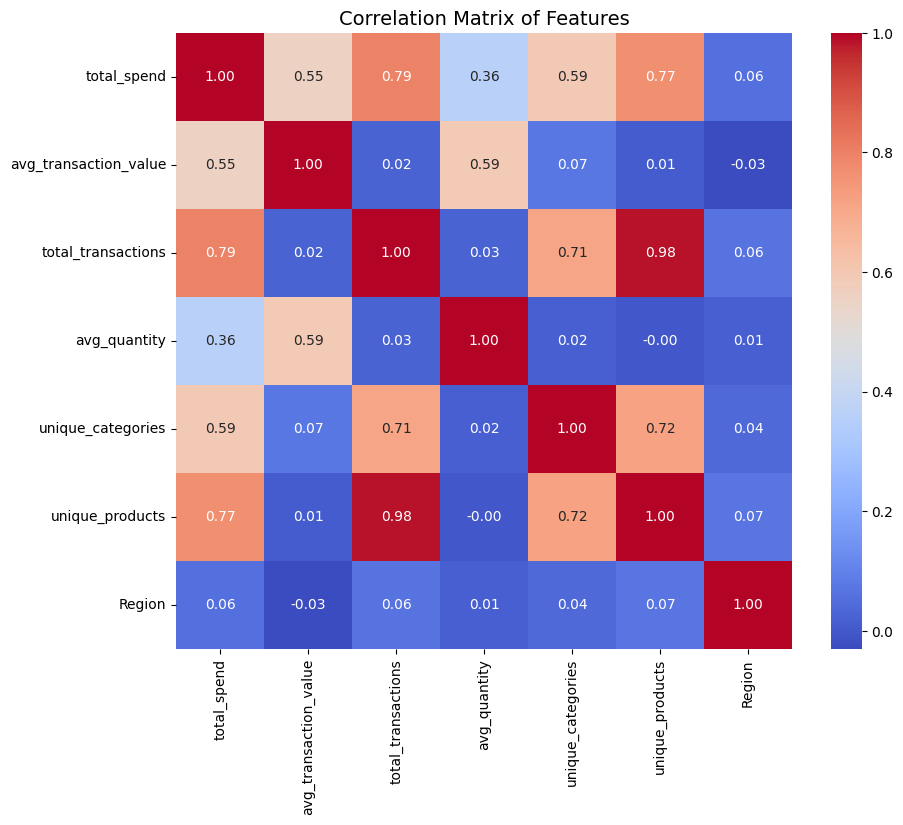

In [7]:
# Correlation analysis of features
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = customer_features.drop(columns=["CustomerID"]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Features", fontsize=14)
plt.show()


**Validating Similarity Scores**

In [13]:
# Validate similarity scores
example_customer_idx = 0  # Example for Customer C0001
example_customer_features = normalized_features[example_customer_idx]
similarity_scores = cosine_similarity([example_customer_features], normalized_features).flatten()

# Compare features of top matches
top_matches = similarity_scores.argsort()[::-1][1:4]  # Skip self (index 0)
for idx in top_matches:
    print(f"CustomerID: {customer_features.iloc[idx]['CustomerID']}")
    print(customer_features.iloc[idx])
    print(f"Similarity Score: {similarity_scores[idx]:.3f}")
    print()


CustomerID: C0107
CustomerID                 C0107
total_spend              3623.92
avg_transaction_value    724.784
total_transactions             5
avg_quantity                 2.4
unique_categories              3
unique_products                5
Region                         3
Name: 106, dtype: object
Similarity Score: 0.978

CustomerID: C0174
CustomerID                 C0174
total_spend              2891.95
avg_transaction_value     578.39
total_transactions             5
avg_quantity                 2.4
unique_categories              3
unique_products                5
Region                         3
Name: 173, dtype: object
Similarity Score: 0.943

CustomerID: C0011
CustomerID                C0011
total_spend              3730.0
avg_transaction_value     746.0
total_transactions            5
avg_quantity                2.6
unique_categories             3
unique_products               5
Region                        3
Name: 10, dtype: object
Similarity Score: 0.918

